## Importing

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os

from time import sleep
from tqdm.auto import tqdm

import dill


## Datasets Preparation

In [10]:
def datasets_preparation ():

     # Dataset and date    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')

     ds_prod_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_prod_T.nc')

     ds = xr.open_dataset (ds_name)
     ds_bio = xr.open_dataset (ds_bio_name)
     ds_prod = xr.open_dataset(ds_prod_name)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
          [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
          [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
          [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
          [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     diat_i = ((ds_prod.PPDIAT.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
          [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]) / ((ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
          [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27])
     # flag_i = ((ds_prod.PPPHY.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
     #       [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]) / ((ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
     #      [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27])

     return (temp_i1, temp_i2, saline_i1, saline_i2, diat_i)


## Regressor

In [11]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    extra_tree = ExtraTreeRegressor(criterion='poisson')
    regr = BaggingRegressor(extra_tree, n_estimators=10, max_features=4).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),8)
    

    return (r, rms, m, regr)

# Printing

In [12]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),8))


## Scatter Plot

In [13]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing(targets, outputs, m)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,outputs, alpha = 0.2, s = 10)

    lims = [
    np.min([ax[0].get_xlim(), ax[0].get_ylim()]),  # min of both axes
    np.max([ax[0].get_xlim(), ax[0].get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('outputs')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,outputs, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1)
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('outputs')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [14]:
def plotting (variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.legend(['diatom','flagellate'])
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Regressor 2

In [15]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)

    m = scatter_plot(targets, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = np.round(mse(targets, outputs_test),4)

    return (r, rms, m)

## Training of 2007

Gathering days for year 2007


days of 2007:   0%|          | 0/75 [00:00<?, ?it/s]

Done gathering, building the prediction model


The amount of data points is 871482
The slope of the best fitting line is  0.87
The correlation coefficient is: 0.94
 The mean square error is: 0.0


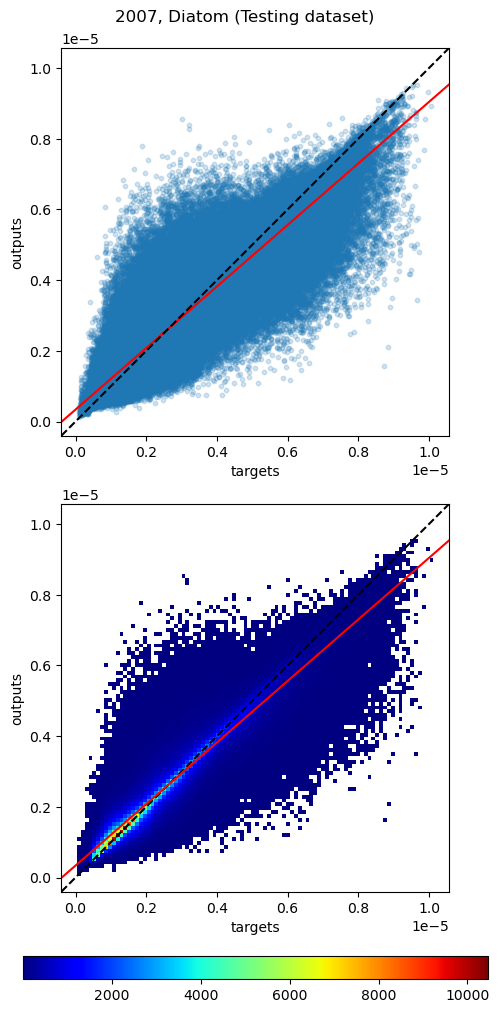

In [16]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

year = 2007

year_str = str(year)[2:4]

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

drivers_all = np.array([[],[],[],[]])
diat_all = np.array([])

print ('Gathering days for year ' + str(year))

for i in tqdm(folders, desc='days of ' + str(year), colour = 'green'):

    temp_i1, temp_i2, saline_i1, saline_i2, diat_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]
    drivers_all = np.concatenate((drivers_all,drivers),axis=1)

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]
    diat_all = np.concatenate((diat_all,diat))

    sleep(0.1)

print ('Done gathering, building the prediction model')
print ('\n')

r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')



## Other Years

years:   0%|          | 0/17 [00:00<?, ?it/s]

Gathering days for year 2007


days of 2007:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.932
The correlation coefficient is: 0.977
 The mean square error is: 0.0


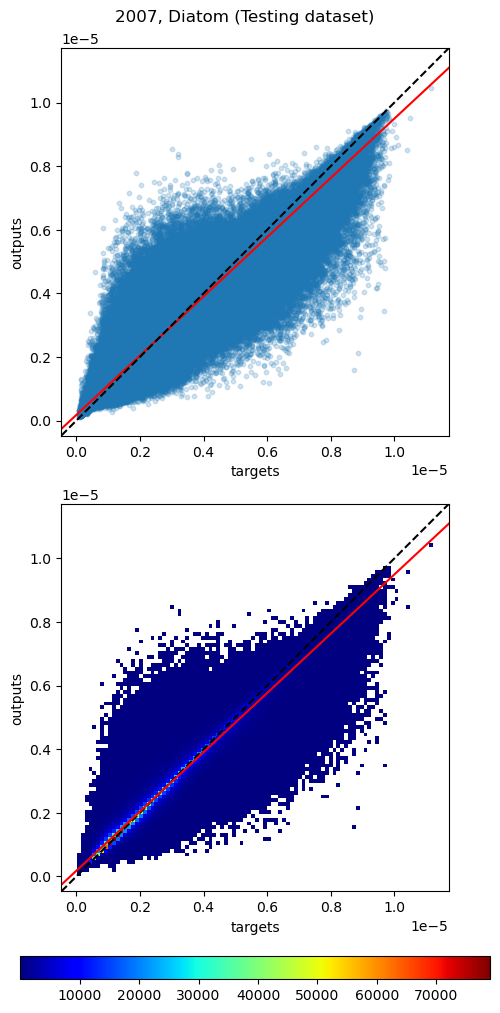

Gathering days for year 2008


days of 2008:   0%|          | 0/76 [00:00<?, ?it/s]

The amount of data points is 3532404
The slope of the best fitting line is  0.532
The correlation coefficient is: 0.536
 The mean square error is: 0.0


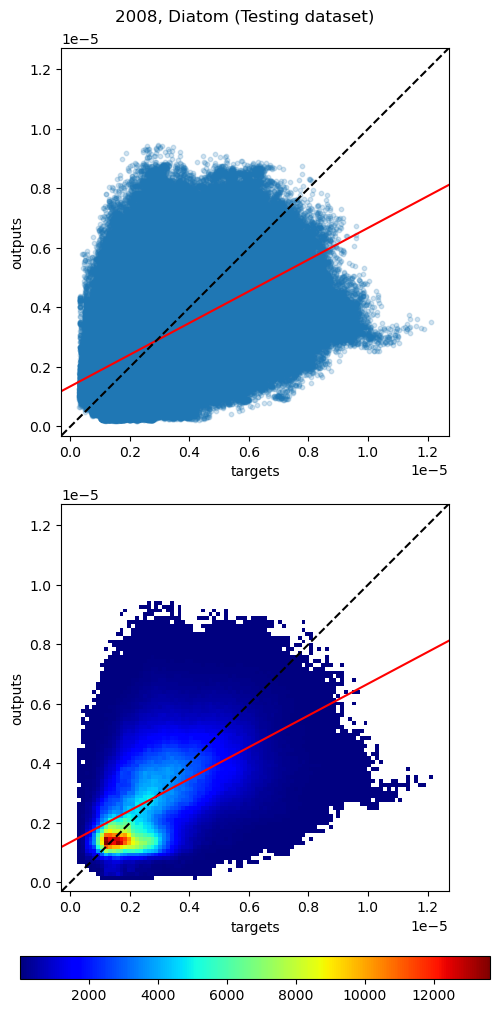

Gathering days for year 2009


days of 2009:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.509
The correlation coefficient is: 0.581
 The mean square error is: 0.0


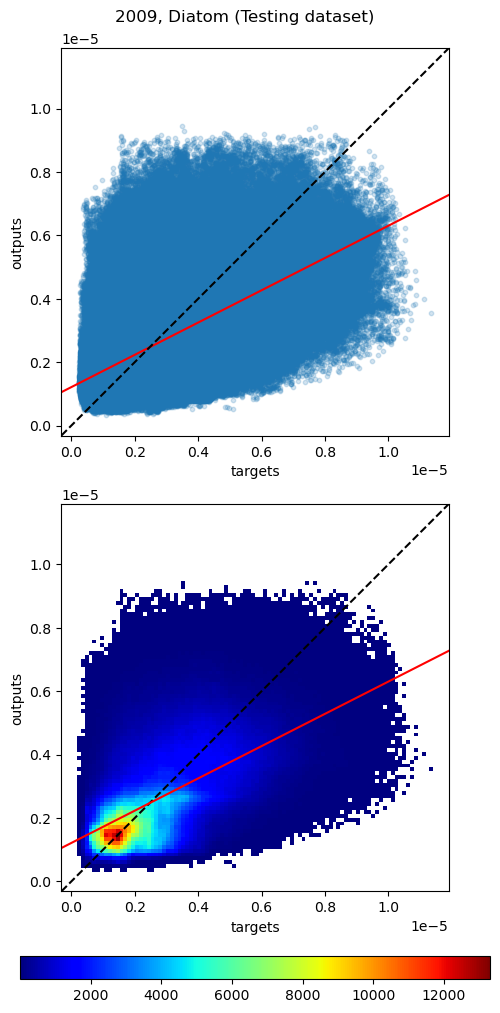

Gathering days for year 2010


days of 2010:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.45
The correlation coefficient is: 0.531
 The mean square error is: 0.0


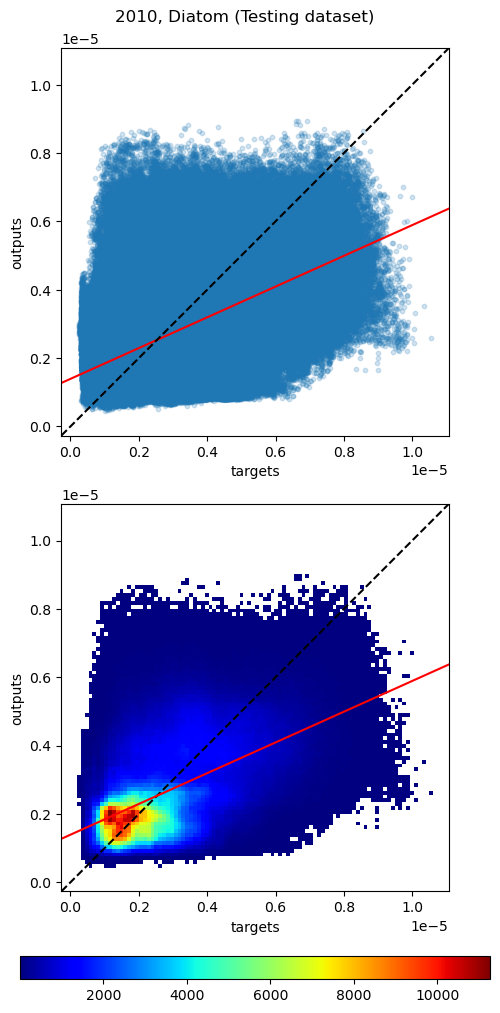

Gathering days for year 2011


days of 2011:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.477
The correlation coefficient is: 0.533
 The mean square error is: 0.0


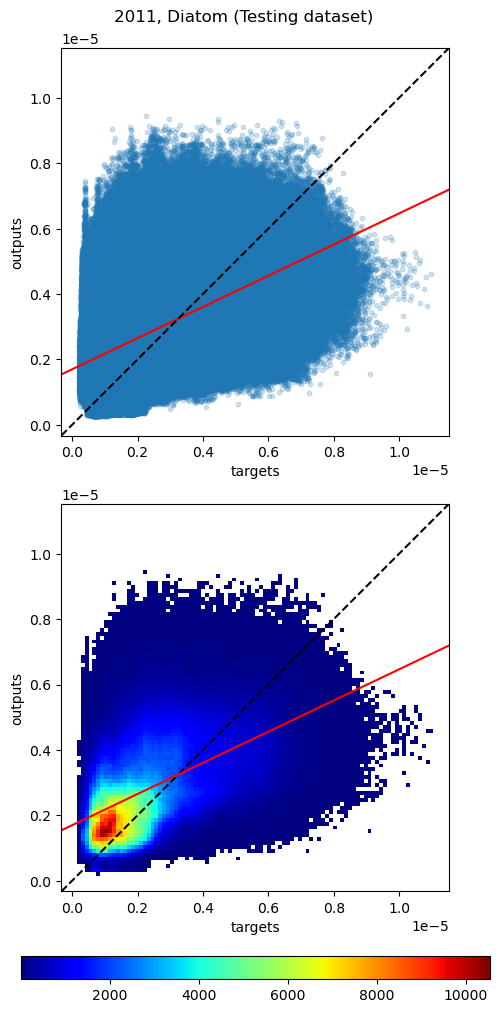

Gathering days for year 2012


days of 2012:   0%|          | 0/76 [00:00<?, ?it/s]

The amount of data points is 3532404
The slope of the best fitting line is  0.525
The correlation coefficient is: 0.565
 The mean square error is: 0.0


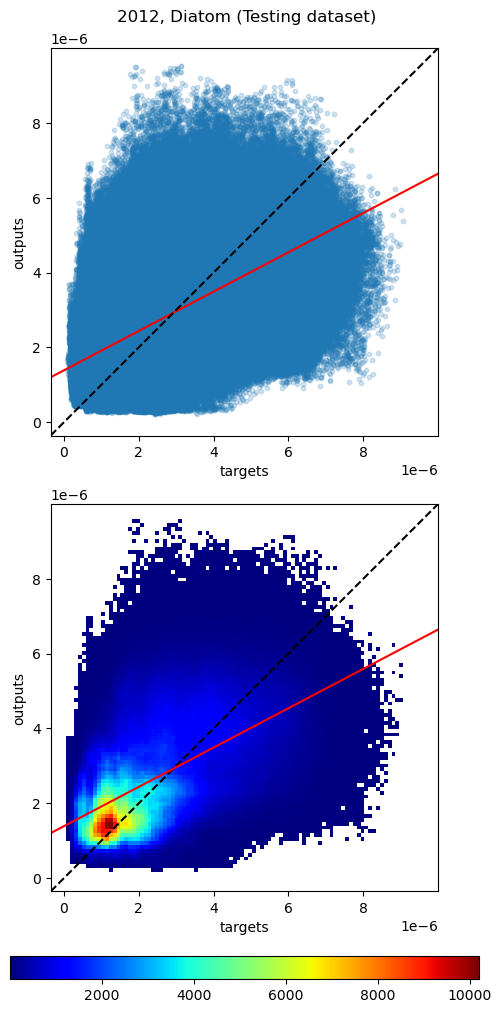

Gathering days for year 2013


days of 2013:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.518
The correlation coefficient is: 0.597
 The mean square error is: 0.0


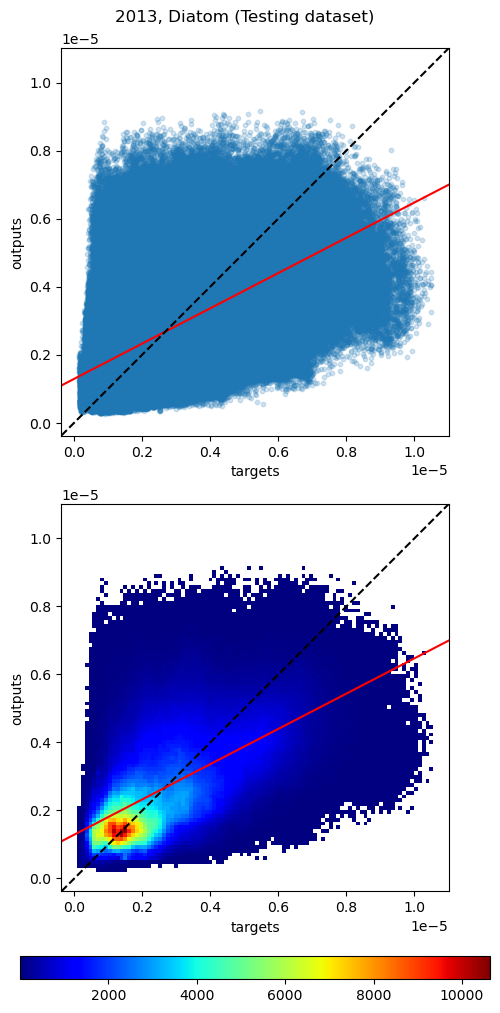

Gathering days for year 2014


days of 2014:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.494
The correlation coefficient is: 0.574
 The mean square error is: 0.0


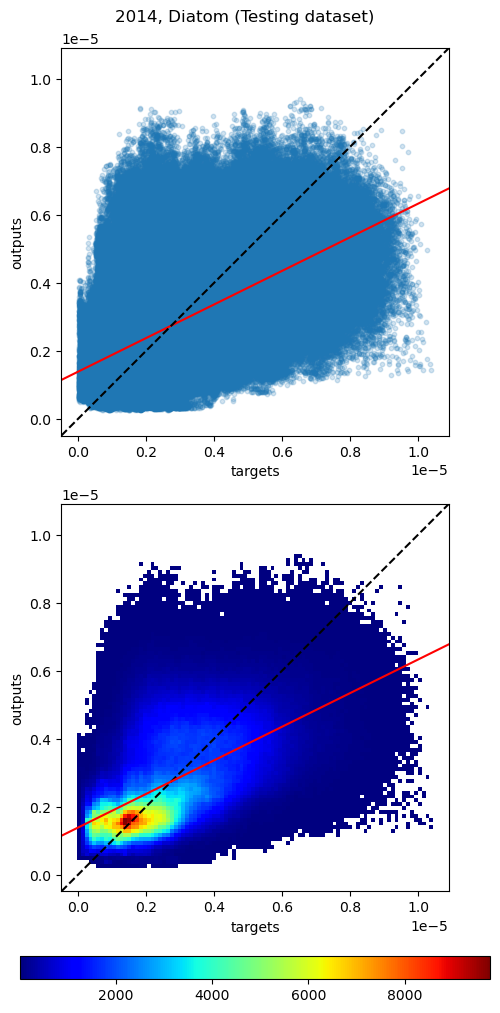

Gathering days for year 2015


days of 2015:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.355
The correlation coefficient is: 0.379
 The mean square error is: 0.0


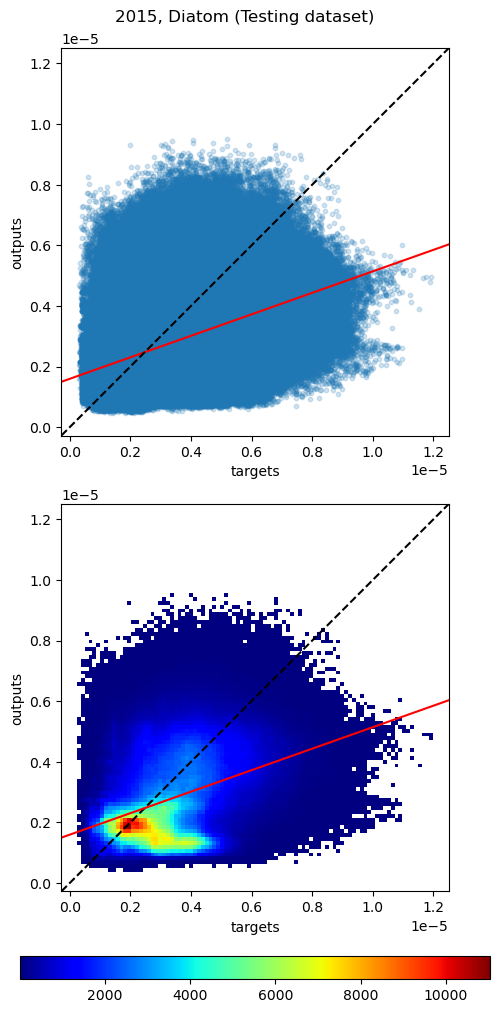

Gathering days for year 2016


days of 2016:   0%|          | 0/76 [00:00<?, ?it/s]

The amount of data points is 3532404
The slope of the best fitting line is  0.381
The correlation coefficient is: 0.5
 The mean square error is: 0.0


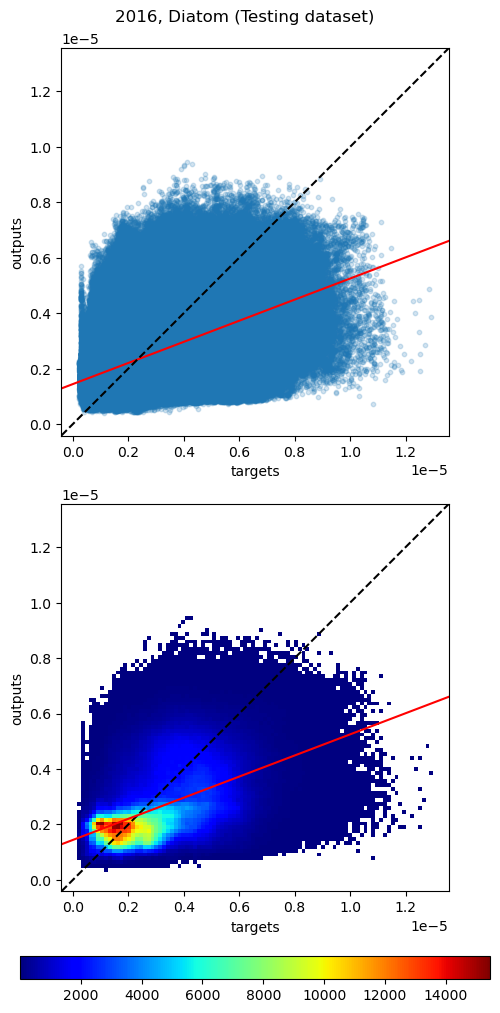

Gathering days for year 2017


days of 2017:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.545
The correlation coefficient is: 0.567
 The mean square error is: 0.0


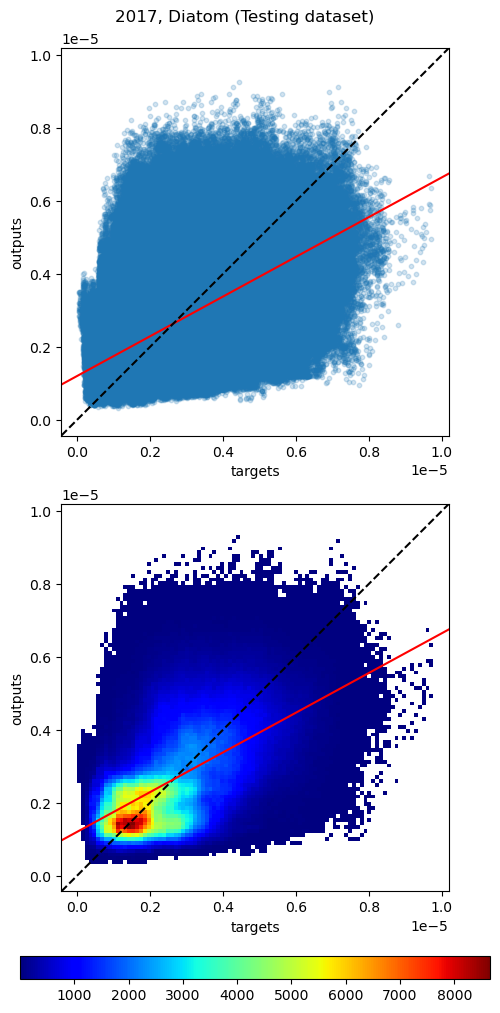

Gathering days for year 2018


days of 2018:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.404
The correlation coefficient is: 0.404
 The mean square error is: 0.0


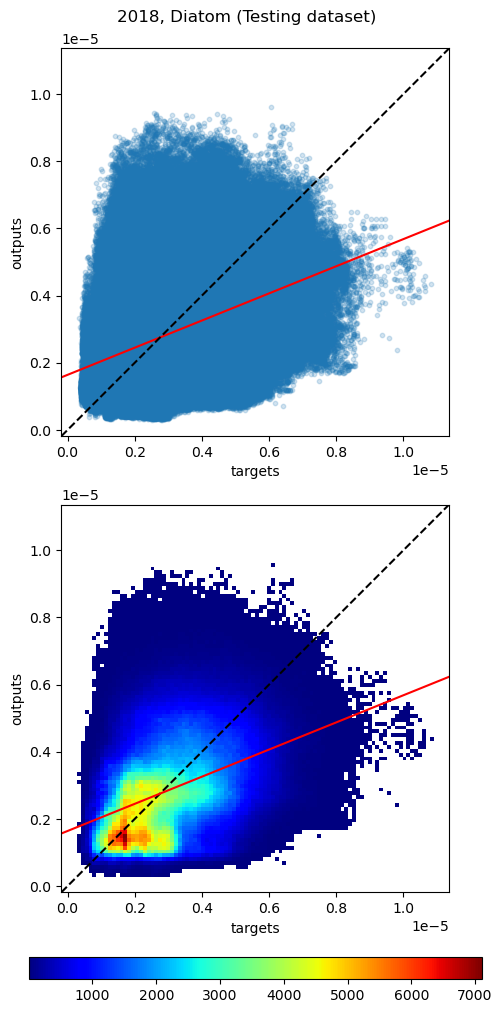

Gathering days for year 2019


days of 2019:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.429
The correlation coefficient is: 0.489
 The mean square error is: 0.0


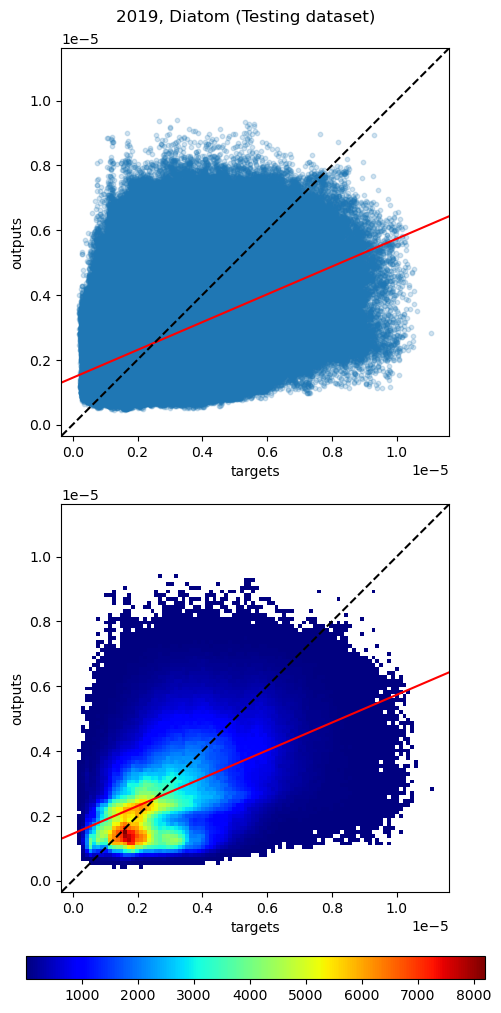

Gathering days for year 2020


days of 2020:   0%|          | 0/76 [00:00<?, ?it/s]

The amount of data points is 3532404
The slope of the best fitting line is  0.358
The correlation coefficient is: 0.403
 The mean square error is: 0.0


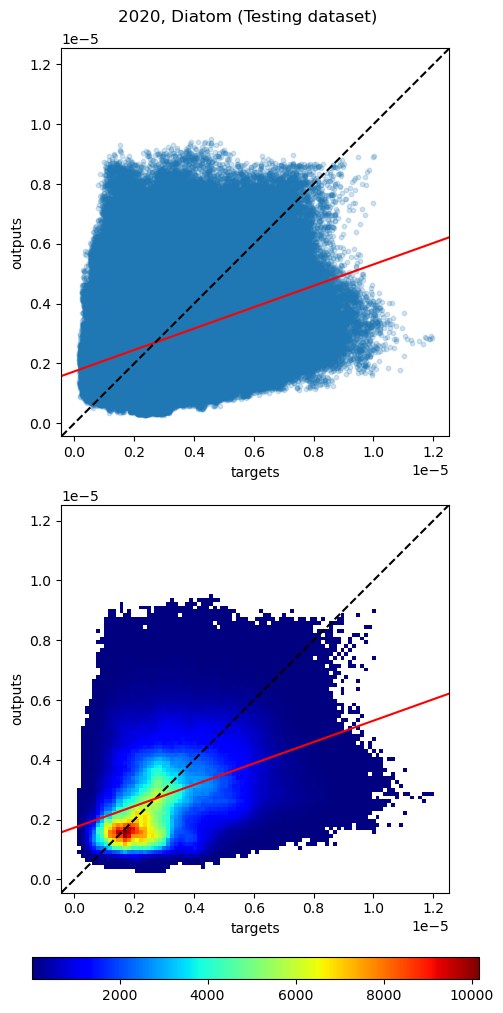

Gathering days for year 2021


days of 2021:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.54
The correlation coefficient is: 0.594
 The mean square error is: 0.0


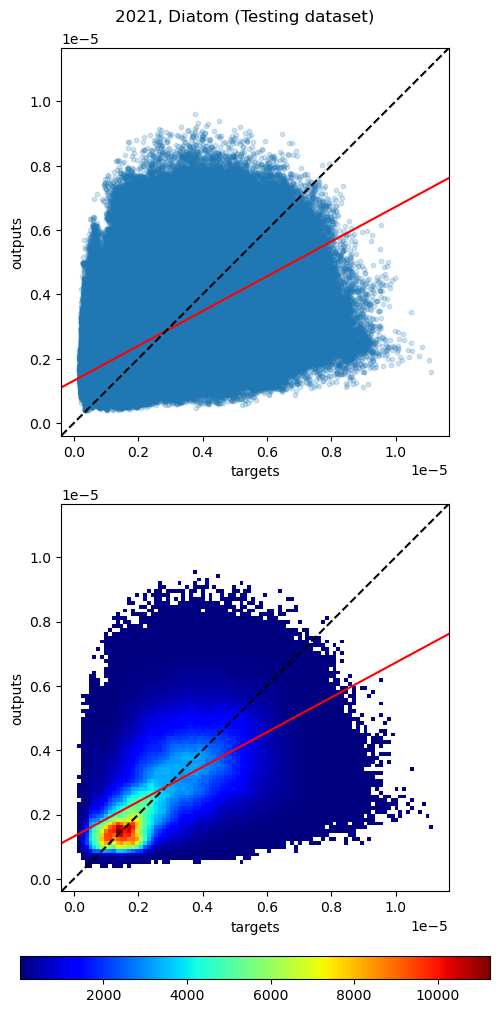

Gathering days for year 2022


days of 2022:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.484
The correlation coefficient is: 0.5
 The mean square error is: 0.0


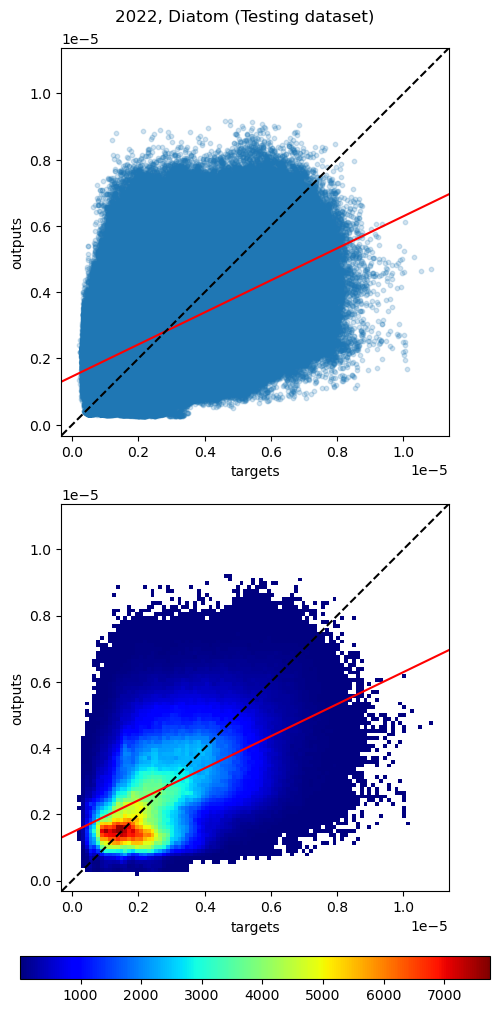

Gathering days for year 2023


days of 2023:   0%|          | 0/75 [00:00<?, ?it/s]

The amount of data points is 3485925
The slope of the best fitting line is  0.427
The correlation coefficient is: 0.53
 The mean square error is: 0.0


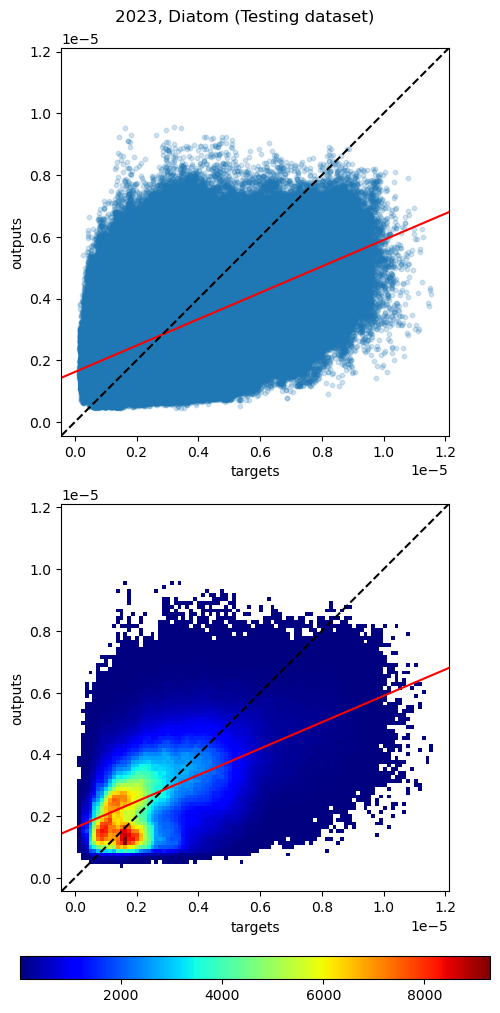

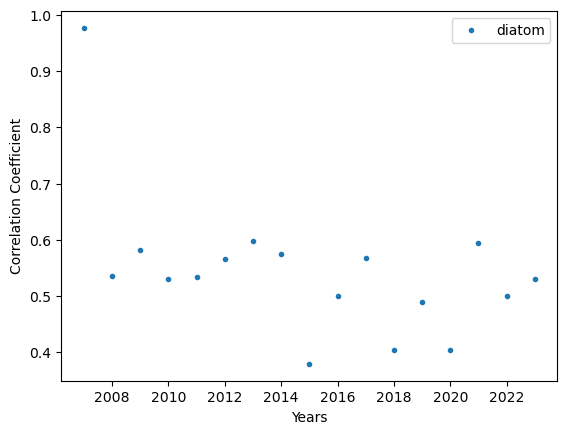

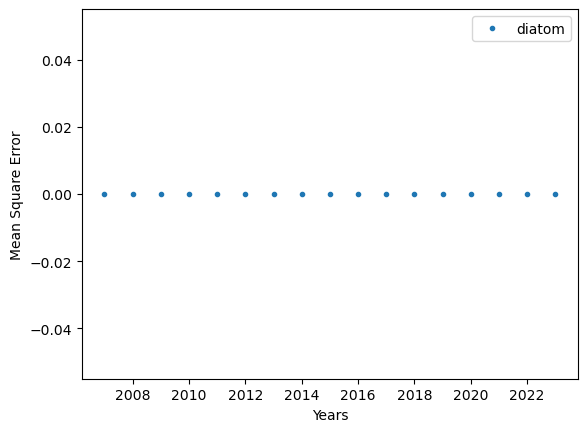

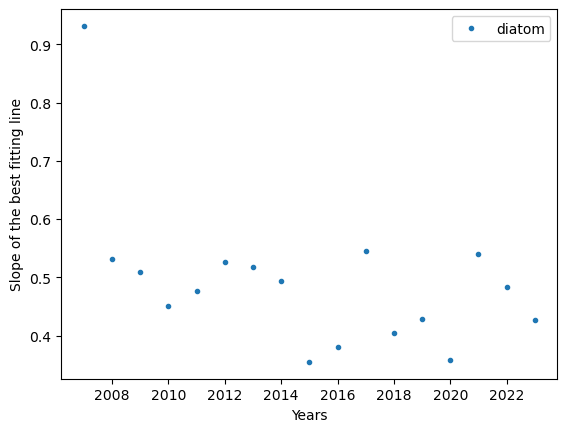

In [17]:
years = range (2007,2024)

r_all = []
rms_all = []
slope_all = []

for year in tqdm(range (2007,2024), desc='years'):

    year_str = str(year)[2:4]

    folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
    indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
    folders = [folders[i] for i in indx_dates]

    drivers_all = np.array([[],[],[],[]])
    diat_all = np.array([])

    print ('Gathering days for year ' + str(year))
    
    for i in tqdm(folders, desc='days of ' + str(year), colour = 'green'):

        temp_i1, temp_i2, saline_i1, saline_i2, diat_i = datasets_preparation()

        drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
        indx = np.where(~np.isnan(drivers).any(axis=0))
        drivers = drivers[:,indx[0]]
        drivers_all = np.concatenate((drivers_all,drivers),axis=1)

        diat = np.ravel(diat_i)
        diat = diat[indx[0]]
        diat_all = np.concatenate((diat_all,diat))

        sleep(0.1)

    r, rms, m = regressor2(drivers_all, diat_all, 'Diatom')
    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)

    sleep(0.1)
    
plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')
